In [ ]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from dataclasses import dataclass

from zipfile import ZipFile
from urllib.request import urlretrieve


In [ ]:
SEED_VALUE = 41

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)


In [ ]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [ ]:
URL = r"https://www.dropbox.com/s/uzgh5g2bnz40o13/dataset_traffic_signs_40_samples_per_class.zip?dl=1"

dataset_path   = os.path.join(os.getcwd(), "dataset_traffic_signs_40_samples_per_class")
asset_zip_path = os.path.join(os.getcwd(), "dataset_traffic_signs_40_samples_per_class.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 43
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3

    DATA_ROOT_TRAIN:  str = os.path.join(dataset_path, "Train")
    DATA_ROOT_VALID:  str = os.path.join(dataset_path, "Valid")
    DATA_ROOT_TEST:   str = os.path.join(dataset_path, "Test")
    DATA_TEST_GT:     str = os.path.join(dataset_path, "Test.csv")


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8

In [ ]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int', # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int', # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

Found 1204 files belonging to 43 classes.
Found 516 files belonging to 43 classes.


In [ ]:
# Display the class names from the training dataset.
print(train_dataset.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


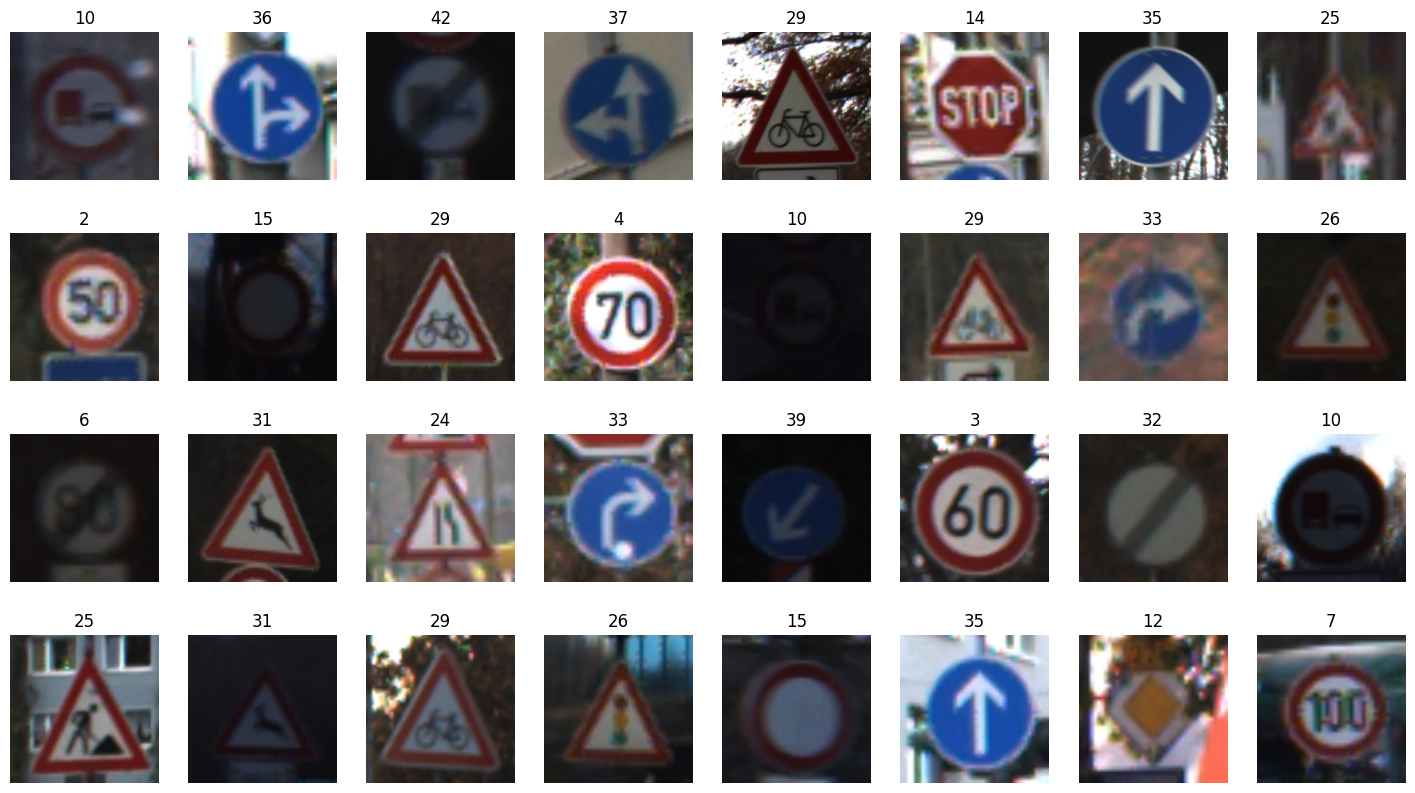

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1):
    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

In [ ]:
import pandas as pd

input_file = DatasetConfig.DATA_TEST_GT

dataset = pd.read_csv(input_file)
df = pd.DataFrame(dataset)
cols = [6]
df = df[df.columns[cols]]
ground_truth_ids = df["ClassId"].values.tolist()
print("Total number of Test labels: ", len(ground_truth_ids))
print(ground_truth_ids[0:10])

Total number of Test labels:  12630
[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]


In [ ]:
# For referenece, let's print the class names from the train/valid datasets again.
print(train_dataset.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [ ]:


# Convert train/valid class names to integers.
class_names_int = list(map(int, train_dataset.class_names))

# Create a dictionary mapping ground truth IDs to class name IDs.
gtid_2_cnidx = dict(zip(class_names_int, range(0, DatasetConfig.NUM_CLASSES)))

gtid_2_cnidx.items()



dict_items([(0, 0), (1, 1), (10, 2), (11, 3), (12, 4), (13, 5), (14, 6), (15, 7), (16, 8), (17, 9), (18, 10), (19, 11), (2, 12), (20, 13), (21, 14), (22, 15), (23, 16), (24, 17), (25, 18), (26, 19), (27, 20), (28, 21), (29, 22), (3, 23), (30, 24), (31, 25), (32, 26), (33, 27), (34, 28), (35, 29), (36, 30), (37, 31), (38, 32), (39, 33), (4, 34), (40, 35), (41, 36), (42, 37), (5, 38), (6, 39), (7, 40), (8, 41), (9, 42)])

In [ ]:
# Convert the ground truth Class IDs to IDs that correctly map to the same classes
# in the train and validation datasets.
label_ids = []
for idx in range(len(ground_truth_ids)):
    label_ids.append(gtid_2_cnidx[ground_truth_ids[idx]])

print("Original ground truth class IDs: ", ground_truth_ids[0:10])
print("New mapping required:            ", label_ids[0:10])
print("")
print("Train/Valid dataset class names: ", train_dataset.class_names)

Original ground truth class IDs:  [16, 1, 38, 33, 11, 38, 18, 12, 25, 35]
New mapping required:             [8, 1, 32, 27, 3, 32, 10, 4, 18, 29]

Train/Valid dataset class names:  ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [ ]:
# Get all the path names to the Test images (will prune later)
image_paths = sorted(glob.glob(DatasetConfig.DATA_ROOT_TEST + os.sep + "*.png"))

print(len(image_paths))
print("")
# Print the first 5 image paths to confirm.
for idx in range(5):
    print(image_paths[idx])



12630

/content/dataset_traffic_signs_40_samples_per_class/Test/00000.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00001.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00002.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00003.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00004.png


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_ids))

In [ ]:
def preprocess_image(image):
    # Decode and resize image.
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH])
    return image


In [ ]:
def load_and_preprocess_image(path):
    # Read image into memory as a byte string.
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [ ]:
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label


In [ ]:


# Apply the functions above to the test dataset.
test_dataset = test_dataset.map(load_and_preprocess_from_path_label)

# Set the batch size for the dataset.
test_dataset = test_dataset.batch(TrainingConfig.BATCH_SIZE)



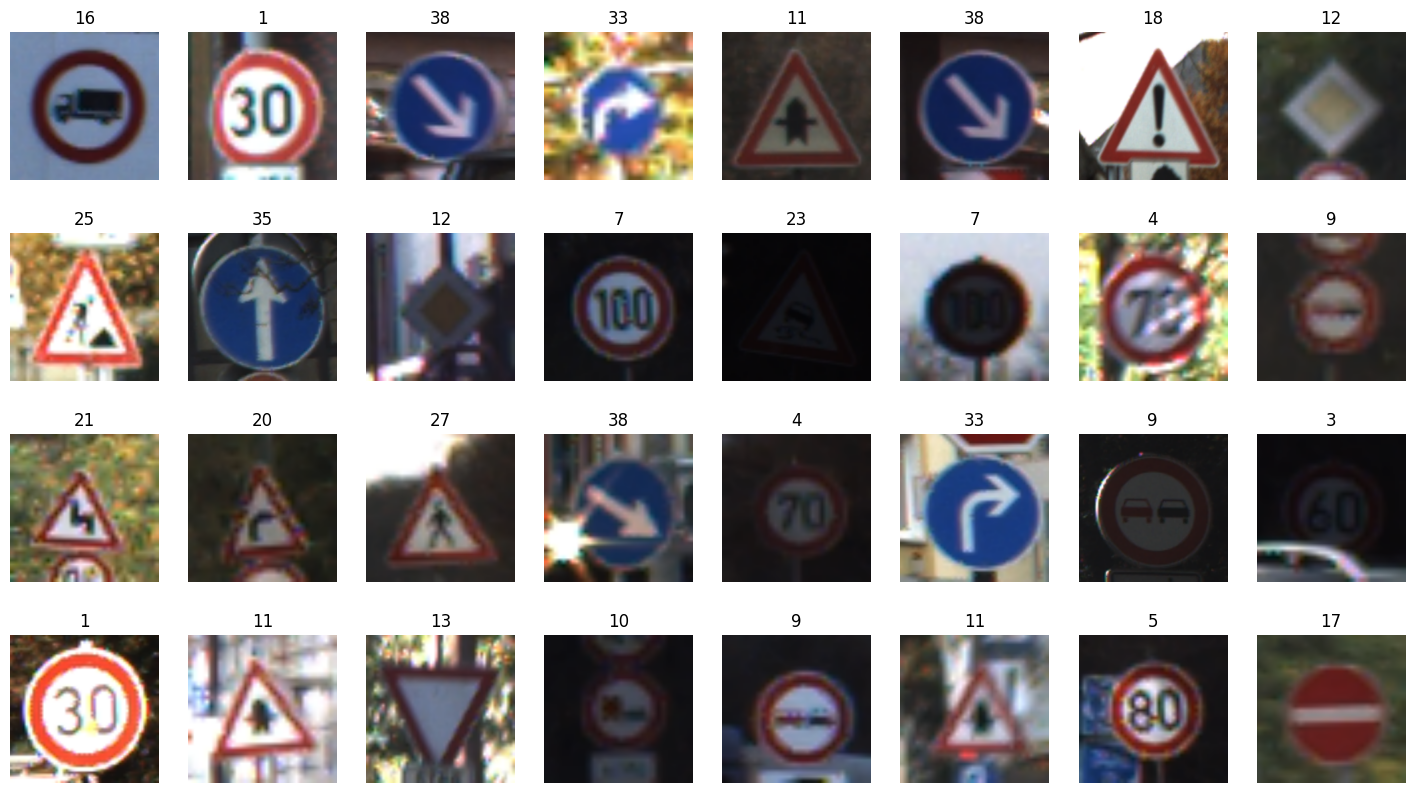

In [ ]:
plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the test dataset.
for image_batch, labels_batch in test_dataset.take(1):

    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")


In [ ]:
tf.keras.applications.vgg16.VGG16(include_top=True,
                                  weights='imagenet',
                                  input_tensor=None,
                                  input_shape=None,
                                  pooling=None,
                                  classes=1000,
                                  classifier_activation='softmax',
                                 )

553467096/553467096 [==============================] - 8s 0us/step


In [ ]:
# Specify the model input shape.
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
vgg16_conv_base.summary()

Loading model with ImageNet weights...
58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                       

In [ ]:
 #Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
vgg16_conv_base.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[: num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last {num_layers_fine_tune} convolutional layers...")
print("\n")

vgg16_conv_base.summary()

FREEZING LAYER: <keras.src.engine.input_layer.InputLayer object at 0x7c3646480430>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c36464838e0>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c3646694f10>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c364b5b1000>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c36465e9a80>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c3646495060>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c3646497880>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c3646494430>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c3646495120>
FREEZING LAYER: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c3646496860>
FREEZING LAYER: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c36464c7190>


Configured to 

In [ ]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)

x = vgg16_conv_base(x)

# Flatten the output from the convolutional base.
x = layers.Flatten()(x)

# Add the classifier.
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)

# Output layer.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation="softmax")(x)

# The final model.
model_vgg16_finetune = keras.Model(inputs, outputs)

model_vgg16_finetune.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               321139

In [ ]:
# Use this for integer encoded labels.
model_vgg16_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)


In [ ]:
# Train the Model.
training_results = model_vgg16_finetune.fit(train_dataset,
                                            epochs=TrainingConfig.EPOCHS,
                                            validation_data=valid_dataset,
                                           )

